In [82]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 표시 해결
# 한글설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # windows 사용자
# matplotlib.rcParams['font.family'] = 'AppleGothic Gothic' # Mac사용자
matplotlib.rcParams['font.size'] = '10' # 글자크기

In [83]:
(train_input,train_target),(test_input,test_target) = keras.datasets.fashion_mnist.load_data()

In [124]:
train_input.shape

(60000, 28, 28)

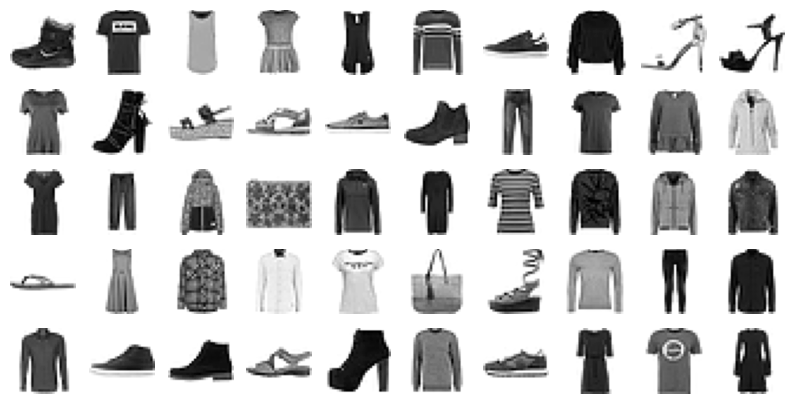

In [85]:
fig,axs = plt.subplots(5,10,figsize=(10,5))
for i in range(5):
    for j in range(10):
        axs[i,j].imshow(train_input[i*10+j],cmap='gray_r')
        axs[i,j].axis('off')
plt.show()


In [86]:
# 세트 - train 세트, 검증 세트, test 세트 
# 표준화작업
train_scaled = train_input.reshape(-1,28,28,1)/255.0

In [87]:
train_scaled,val_scaled,train_target,val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [97]:
train_scaled.shape

(48000, 28, 28, 1)

In [89]:
# 세임패딩 : 입력과 특성맵의 크기를 동일하게 만들기 위해 입력 주위에 0으로 패딩하는 것
# padding='same': 패딩 사용
# padding='valid': 패딩사용하지 않음, 밸리드패딩 : 패딩없이 순수한 입력 배열에서만 합성곱
# input_shape = (28,28,1): 사이즈는 28x28 그레이색상 1, (28,28,3) : 사이즈 28x28, RGB색상 3개
# strides = 1 : 1칸씩 이동, 1이 default값: 코드를 쓰지 않아도 1칸씩 이동한다
# 패딩
# 풀링 : 특성맵의 가로세로 크기를 줄이는 역할 - 최대풀링,평균풀링

1차 합성곱 층을 생성

In [90]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',\
    input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(2,padding='valid'))

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2차 합성곱 신경망

In [91]:
# 2차 합성곱 신경망
model.add( keras.layers.Conv2D( 64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2,padding='valid')) # 최대풀링

In [92]:
model.add(keras.layers.Flatten()) # 다시 1차원 모양으로 바뀜
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.4)) # 60%만 사용
model.add(keras.layers.Dense(10,activation='softmax'))

In [93]:
14*14*32

6272

In [98]:
model.summary()

# conv2d param 사이즈 : kernel_size(3,3) x 깊이(1) x 필터(32개) + 32개 절편 = 3x3x1x32+32
# 

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

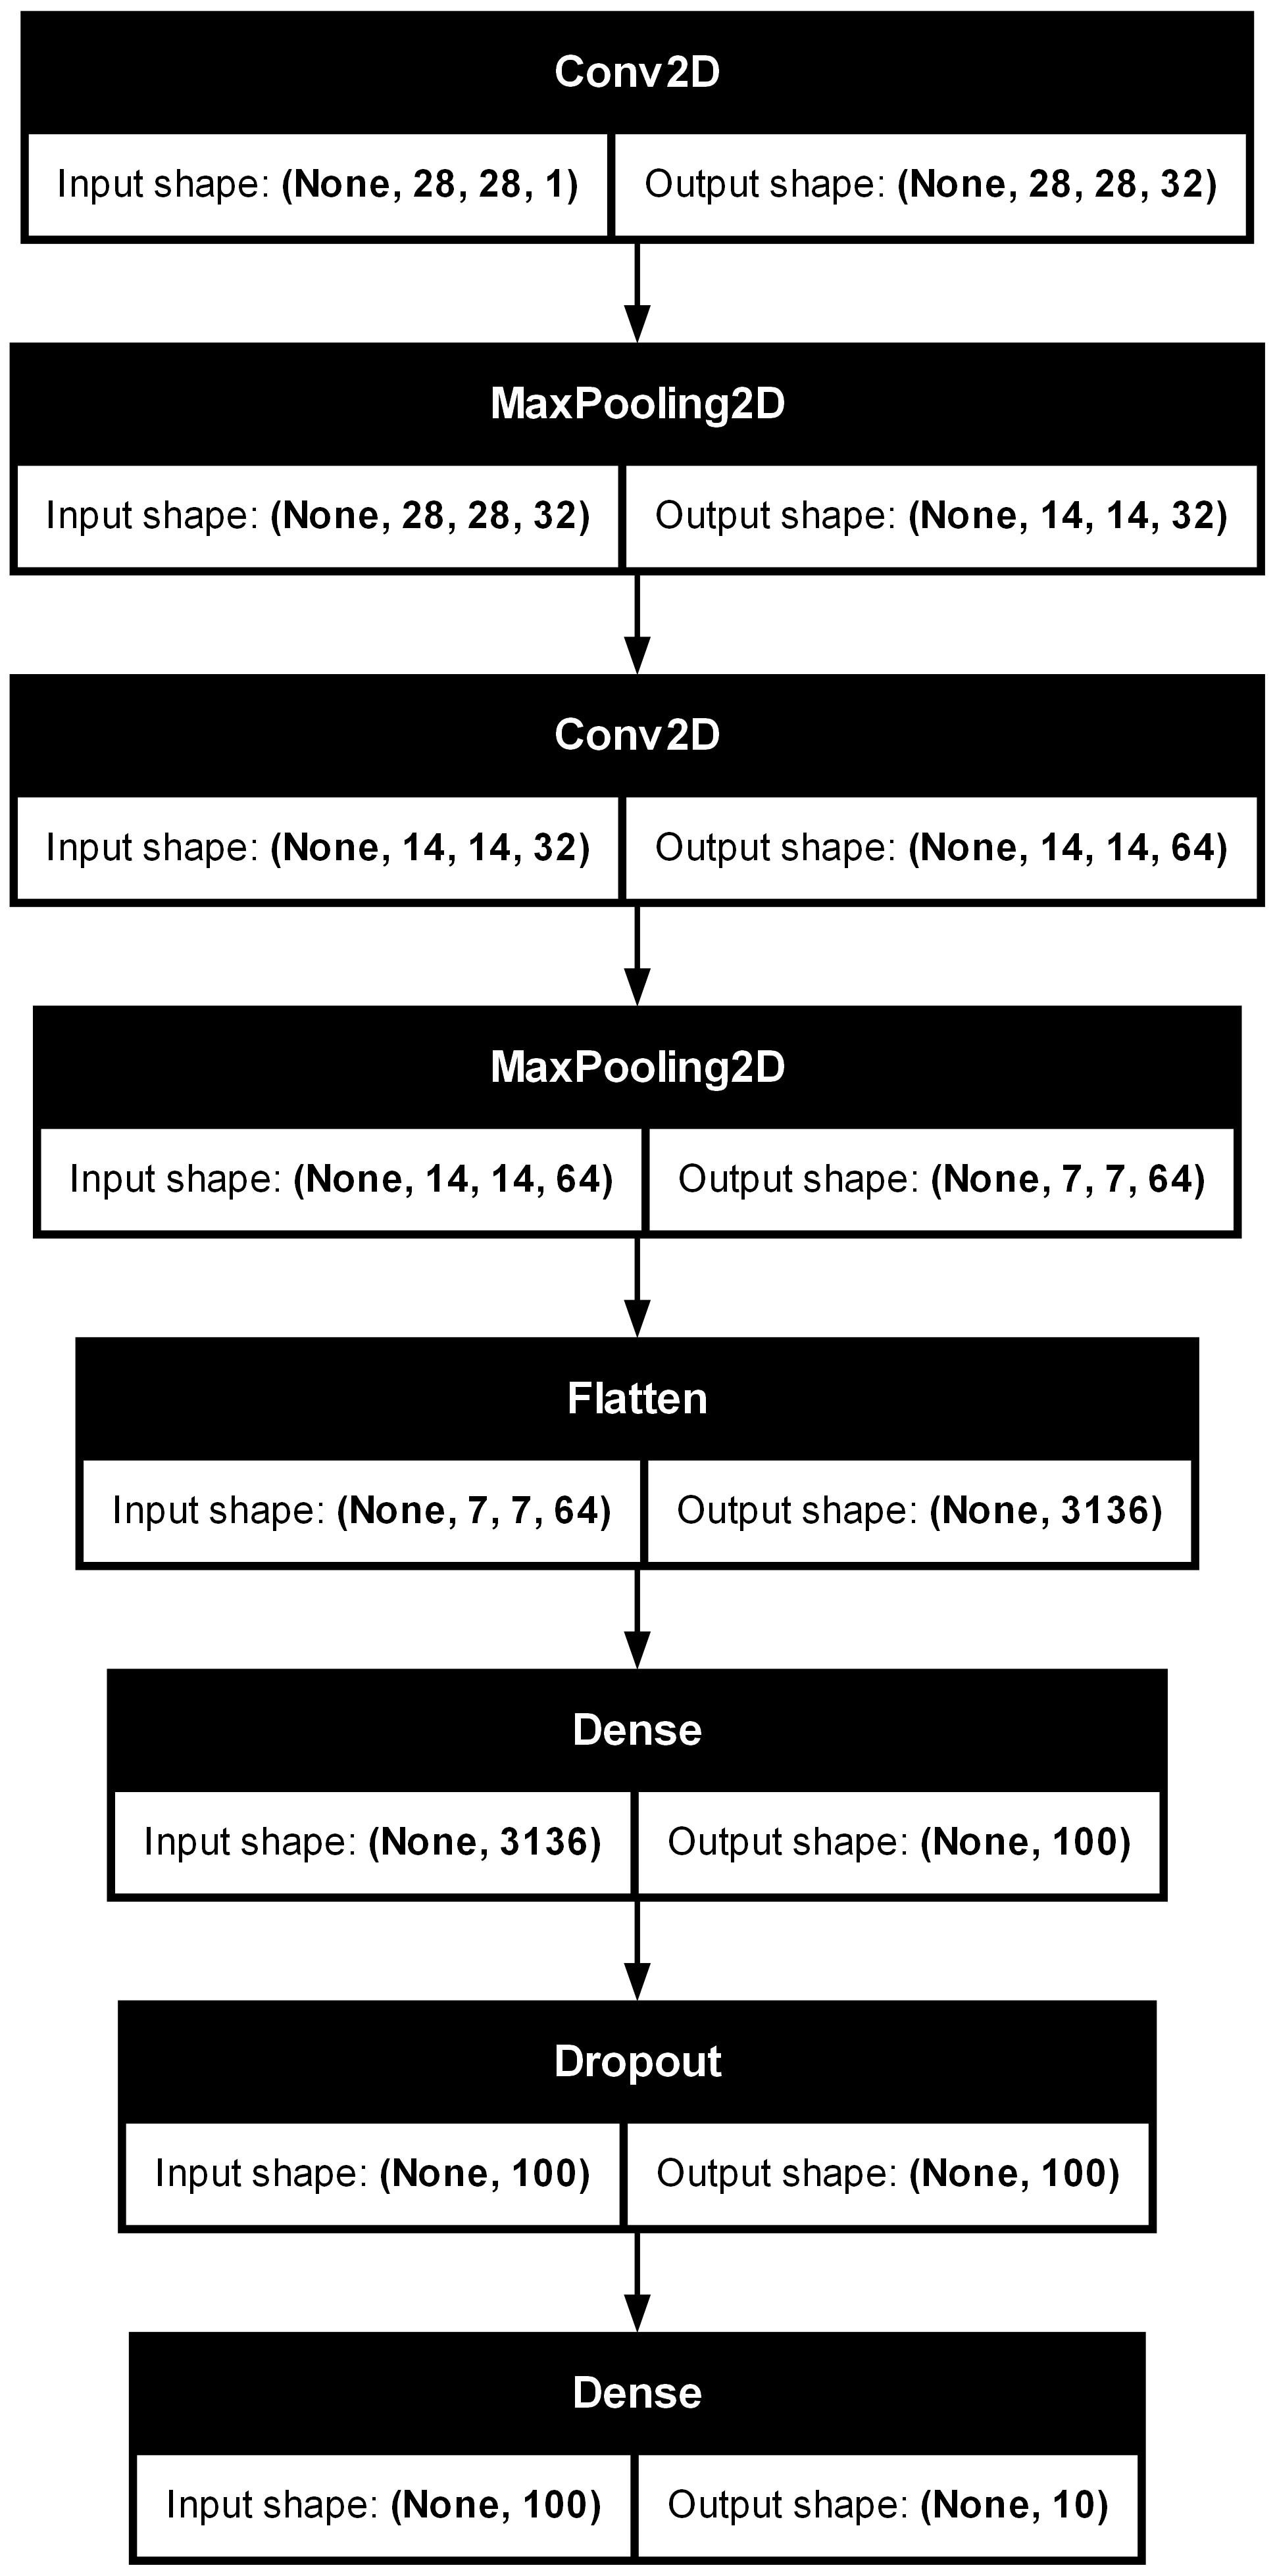

In [95]:
keras.utils.plot_model(model,show_shapes=True, to_file='cnn_a.png',dpi=300)

In [100]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('cnn_model.keras')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
history = model.fit(train_scaled,train_target,batch_size=32,epochs=20, 
                    validation_data=(val_scaled,val_target),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7421 - loss: 0.7165 - val_accuracy: 0.8798 - val_loss: 0.3257
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8745 - loss: 0.3498 - val_accuracy: 0.8965 - val_loss: 0.2759
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8925 - loss: 0.3004 - val_accuracy: 0.9032 - val_loss: 0.2561
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9051 - loss: 0.2612 - val_accuracy: 0.9146 - val_loss: 0.2329
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9124 - loss: 0.2327 - val_accuracy: 0.9111 - val_loss: 0.2375
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9205 - loss: 0.2144 - val_accuracy: 0.9150 - val_loss: 0.2231
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9281 - loss: 0.1938 - val_accuracy: 0.9215 - val_loss: 0.2171
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9310 - loss

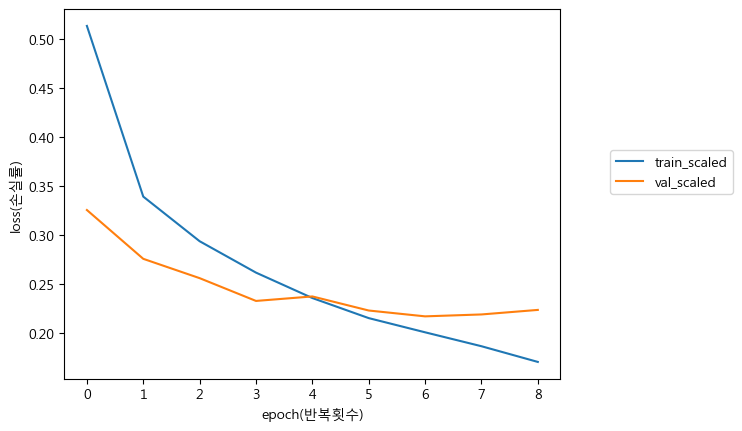

In [102]:
plt.plot(history.history['loss'],label='train_scaled')
plt.plot(history.history['val_loss'],label='val_scaled')
plt.xlabel('epoch(반복횟수)')
plt.ylabel('loss(손실률)')
plt.legend(loc=(1.1,0.5))
plt.show()

In [105]:
early_stopping_cb.stopped_epoch

8

In [104]:
model.evaluate(val_scaled,val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9203 - loss: 0.2152


[0.21713323891162872, 0.921500027179718]

(-0.5, 27.5, 27.5, -0.5)

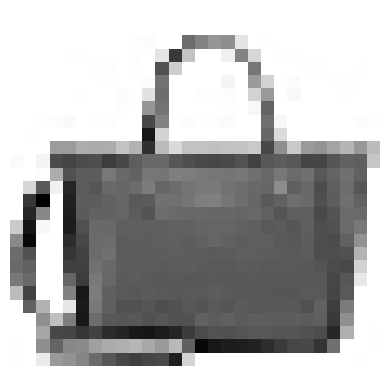

In [109]:
plt.imshow(val_scaled[0].reshape(28,28),cmap='gray_r')
plt.axis('off')

In [111]:
predict = model.predict(val_scaled[0:1])    # 3차원 행렬형태
print(predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[3.8314793e-14 8.0890226e-22 1.5032451e-17 3.7480157e-18 1.2765323e-17
  3.9709014e-17 5.0103534e-17 2.2907326e-17 1.0000000e+00 5.8885437e-18]]


In [112]:
predict[0]

array([3.8314793e-14, 8.0890226e-22, 1.5032451e-17, 3.7480157e-18,
       1.2765323e-17, 3.9709014e-17, 5.0103534e-17, 2.2907326e-17,
       1.0000000e+00, 5.8885437e-18], dtype=float32)

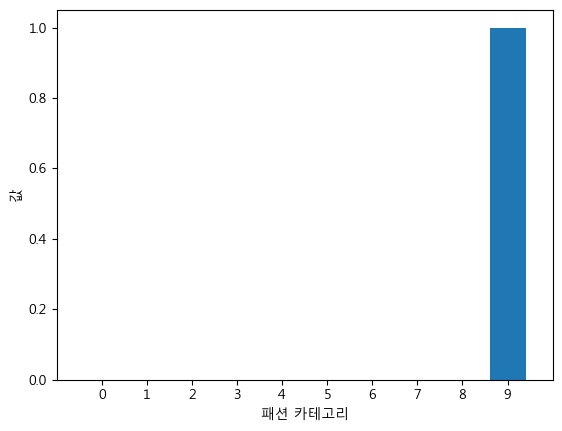

In [120]:
plt.bar(range(1,11),predict[0])
plt.xlabel('패션 카테고리')
plt.xlim(-1,10)
plt.xticks([i for i in range(10)])
plt.ylabel('값')
plt.show()

In [ ]:
# 패션 아이템 카테고리
# 0 : 티셔츠
# 1 : 바지
# 2 : 스웨터
# 3 : 드레스
# 4 : 코트
# 5 : 샌달
# 6 : 셔츠
# 7 : 스니커즈
# 8 : 가방
# 9 : 앵클부츠

In [117]:
classes = ['티셔츠','바지','스웨터','드레스','코트','샌달','셔츠','스니커즈','가방','앵클부츠']

In [118]:
print(classes[np.argmax(predict)])  # np.argmax 최대값의 index 값을 리턴

가방


In [121]:
# test 세트 검증 - 3차원행렬로 변경해서 test진행해야함
test_scaled = test_input.reshape(-1,28,28,1)/255.0

In [122]:
# test 세트 정확도 검증 - 3차원행렬로 변경해서 test진행해야함
model.evaluate(test_scaled,test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9153 - loss: 0.2455


[0.2371162623167038, 0.9172999858856201]

합성곱 신경망 전체 정리

In [96]:
# 딥러닝 훈련 - 인공신경망(ANN)
# 데이터전처리 train_scaled = train_input.reshape(-1,28,28,1)/255.0
# 모델결정 model = keras.Sequential()

# 합성곱 신경망 (CNN)
# 1차 합성곱 신경망 
# 32는 kernel 필터개수
# model.add(keras.layers.Conv2D( 32,kernel_size=(3,3),activation='relu',padding='same'),input_shape=(28,28,1))
# 최대풀링 model.add(keras.layers.MaxPooling2D(2,padding='valid'))

# 2차 합성곱 신경망
# model.add( keras.layers.Conv2D( 64,kernel_size=(3,3),activation='relu',padding='same'))
# model.add(keras.layers.MaxPooling2D(2,padding='valid'))

# 인공신경망 훈련
# model.add(keras.layers.Flatten()) # 다시 1차원 모양으로 바뀜
# model.add(keras.layers.Dense(100,activation='relu'))
# model.add(keras.layers.Dropout(0.4)) # 40%를 제외시킴
# model.add(keras.layers.Dense(10,activation='softmax'))

# 모델설정 옵티마이저 - adam
# # 옵티마이저 - adam
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# 콜백모델체크포인트 checkpoint_cb = keras.callbacks.ModelCheckpoint('cnn_model.keras')
# 조기종료 early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True )
# 모델훈련 history = model.fit(train_scaled,train_target,batch_size=32,epochs=20
#                   validation_data=(val_scaled,val_target),callbacks=[checkpoint_cb,early_stopping_cb])
# 모델평가 model.evaluate(val_scaled,val_target)

# test 세트 검증 - 3차원행렬로 변경해서 test진행해야함
# test_scaled = test_input.reshape(-1,28,28,1)/255.0
# test 세트 정확도
# model.evaluate(test_scaled,test_target)